## MSc652 Group 3433 GWP3

| Full Legal Name             | Location (Country) | Email Address             |
|----------------------------|--------------------|---------------------------|
| Chiransh Gulati            | US                 | gulatichiransh@gmail.com  |
| Harshil Sumra              | India              | harshilsumra1997@gmail.com|
| Pritam Biswaranjan Datta   | India              | pritamdattaedu@gmail.com  |

In [325]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cvx
import cvxopt as opt
from numpy.linalg import inv
import datetime as dt
import scipy.optimize as sco
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### General Functions:

In [326]:
def get_return_for_short_period(annualized_return, short_period_in_years):
    # Calculate the scaling factor for the short period (geometric mean)
    scaling_factor = (1 + annualized_return) ** (short_period_in_years) - 1
    return scaling_factor

def plot_weights(dat, title):
    # Create a bar plot for the portfolio weights
    n_assets = 5
    plt.figure(figsize=(7, 3))
    bars = plt.bar(range(n_assets), dat, align='center', color='orange')
    plt.xticks(range(n_assets), tickers)
    plt.xlabel('Asset')
    plt.ylabel('Weight')
    plt.title(title)
    plt.grid(False)

    # Add value labels to the bar plot
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                 ha='center', va='top')

    plt.show()

def calculate_returns( S, percentageAsProduct=False ):
    ret = np.zeros((S.shape[0]-1, S.shape[1]))
    cum_sums = np.zeros(S.shape[1])
    for j in range(0, S.shape[1]):
        cum_return = 0
        S_ret = np.zeros(S.shape[0]-1)
        for i in range(0,S.shape[0]-1):
            if percentageAsProduct==True:
                S_ret[i] = 1+((S[i+1,j]-S[i,j])/S[i,j])
            else:
                S_ret[i] = ((S[i+1,j]-S[i,j])/S[i,j])
        
        cum_return = np.prod(S_ret)-1    
        
        cum_sums[j] = cum_return
        ret[:, j] = S_ret
    
    return ret, cum_sums

# Markowtiz Portfolio Function
import cvxpy as cp
def mean_variance_optimization(detoned_corr_matrix, expected_returns, risk_aversion=1.0):
    num_assets = len(expected_returns)
    
    # Define the portfolio weights as optimization variables
    w = cp.Variable(num_assets)
    
    # Objective function: Minimize portfolio risk (variance)
    portfolio_risk = cp.quad_form(w, detoned_corr_matrix)
    objective = cp.Minimize(portfolio_risk)
    
    # Constraints: Expected portfolio return and sum of weights equal to 1
    expected_portfolio_return = cp.sum(w * expected_returns)
    constraints = [
        expected_portfolio_return >= 0.10,  # Require positive or zero expected return
        cp.sum(w) == 1.0  # Fully invest in the portfolio (sum of weights equals 1)
    ]
    
    # Create the optimization problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the optimization problem
    try:
        problem.solve()
        if problem.status == cp.OPTIMAL:
            # Get the optimized portfolio weights
            portfolio_weights = w.value
            return portfolio_weights
        else:
            print("Optimization problem not solved to optimality.")
            return None
    except cp.SolverError:
        print("Error in solving the optimization problem.")
        return None

### Denoising Functions:

In [327]:
#### Marcenko Pastur Probability Density Function
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

# eVal0: Eigenvalues before denoising.# eVec0: Eigenvectors before denoising.
# eVal1: Eigenvalues after denoising. # eVec1: Eigenvectors after denoising.
# corr1: Denoised correlation matrix. # var0: Variance before denoising.

def denoise_OL(S, do_plot=True):
    
    np.argwhere( np.isnan(S) )
    
    # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
    cor = np.corrcoef(S, rowvar=0) 
    eVal0 , eVec0 = getPCA( cor ) 
    print(np.argwhere(np.isnan(np.diag(eVal0))))
        
    # code snippet 2.4
    T = float(S.shape[0])
    N = S.shape[1]
    q = float(S.shape[0])/S.shape[1] #T/N
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
    nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    
    if do_plot:
        fig = plt.figure()
        ax  = fig.add_subplot(111)
        ax.hist(np.diag(eVal0), density = True, bins=100) #, normed = True)  #normed = True, 
        
        pdf0 = mpPDF(var0, q=S.shape[0]/float(S.shape[1]), pts=N)
        pdf1 = fitKDE( np.diag(eVal0), bWidth=.005) #empirical pdf
        
        #plt.plot(pdf1.keys(), pdf1, color='g') #no point in drawing this
        plt.plot(pdf0.keys(), pdf0, color='r')
        plt.show()
    
    # code snippet 2.5 - denoising by constant residual eigenvalue
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    eVal1, eVec1 = getPCA(corr1)
    
    return eVal0, eVec0, eVal1, eVec1, corr1, var0

#snippet 2.1
#Marcenko-Pastur pdf
#q=T/N 
def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    #Note: 1.0/2*2 = 1.0 not 0.25=1.0/(2*2)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

#snippet 2.2
#Test Marcenko-Pastur Thm
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec
    
def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density) 
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

#snippet 2.3
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    #print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    #print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var
    
# code snippet 2.5 - denoising by constant residual eigenvalue
# Remove noise from corr by fixing random eigenvalue
# Operation invariante to trace(Correlation)
# The Trace of a square matrix is the _Sum_ of its eigenvalues
# The Determinate of the matrix is the _Product_ of its eigenvalues
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1
    
# code snippet 2.6 - detoning
# ref: mlfinlab/portfolio_optimization/risk_estimators.py
# This method assumes a sorted set of eigenvalues and eigenvectors.
# The market component is the first eigenvector with highest eigenvalue.
# it returns singular correlation matrix: 
# "the detoned correlation matrix is singualar, as a result of eliminating (at least) one eigenvector."
# Page 32
def eval_detoned_corr(corr, eigenvalues, eigenvectors, market_component=1):
    """
    De-tones the de-noised correlation matrix by removing the market component.
    The input is the eigenvalues and the eigenvectors of the correlation matrix and the number
    of the first eigenvalue that is above the maximum theoretical eigenvalue and the number of
    eigenvectors related to a market component.
    :param corr: (np.array) Correlation matrix to detone.
    :param eigenvalues: (np.array) Matrix with eigenvalues on the main diagonal.
    :param eigenvectors: (float) Eigenvectors array.
    :param market_component: (int) Number of fist eigevectors related to a market component. (1 by default)
    :return: (np.array) De-toned correlation matrix.
    """
    
    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]
    
    # Calculating the market component correlation
    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)
    
    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark
    
    # Rescaling the correlation matrix to have 1s on the main diagonal
    corr = cov2corr(corr)
    
    return corr
            
def test_detone():
    # ------ Test detone --------
    cov_matrix = np.array([[0.01, 0.002, -0.001],
                           [0.002, 0.04, -0.006],
                           [-0.001, -0.006, 0.01]])
    cor_test = np.corrcoef(cov_matrix, rowvar=0) 
    eVal_test, eVec_test = getPCA(cor_test)
    eMax_test, var_test = findMaxEval(np.diag(eVal_test), q, bWidth=.01)
    nFacts_test = eVal_test.shape[0]-np.diag(eVal_test)[::-1].searchsorted(eMax_test)   
    corr1_test = denoisedCorr(eVal_test, eVec_test, nFacts_test) 
    eVal_denoised_test, eVec_denoised_test = getPCA(corr1_test)
    corr_detoned_denoised_test = eval_detoned_corr(corr1_test, eVal_denoised_test, eVec_denoised_test)       
    eVal_detoned_denoised_test, _ = getPCA(corr_detoned_denoised_test)     
    np.diag(eVal_denoised_test)
    np.diag(eVal_detoned_denoised_test)
    
    expected_detoned_denoised_corr = np.array([ 1.56236229e+00,  1.43763771e+00, -2.22044605e-16])    
    
    np.testing.assert_almost_equal(np.diag(eVal_detoned_denoised_test), expected_detoned_denoised_corr, decimal=4)
    np.testing.assert_almost_equal(sum(np.diag(eVal_denoised_test)), sum(np.diag(eVal_detoned_denoised_test)), decimal=4 )

### Monte Carlo Functions:

In [328]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

# Code snippet 2.7
#Generate a block-diagnoal covariance matrix and a vector of means
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr
    
def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov
    
# Code snippet 2.8
# generating the empirical covariance matrix
def simCovMu(mu0, cov0, nObs, shrink=False):
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    #print(x.shape)
    mu1 = x.mean(axis = 0).reshape(-1,1) #calc mean of columns of rand matrix
    #print(mu1.shape)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_
    else: cov1 = np.cov(x, rowvar=0)
    return mu1, cov1

# code snippet 2.9 
# Denoising of the empirical covariance matrix
# by constant residual eigenvalue method
def deNoiseCov(cov0, q, bWidth):
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0) #denoising by constant residual eigenvalue method
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1
    
# code snippet 2.10
# Derive minimum-variance-portfolio
# Returns a column vector of percentage allocations
# should be subject to lagrangian constraints:
# 1. lambda_1*(sum(expectation(x_i)*x_i) - d = 0
# 2. lambda_2*(sum(x_i - 1))=0
# where d is expected rate of return
# w*=C^−1*μ/I.T*C^−1*μ - is minimum-variance-portfolio
 #short sales are allowed
def optPort(cov, mu = None):
    inv = np.linalg.inv(cov) #The precision matrix: contains information about the partial correlation between variables,
    #  the covariance between pairs i and j, conditioned on all other variables (https://www.mn.uio.no/math/english/research/projects/focustat/publications_2/shatthik_barua_master2017.pdf)
    ones = np.ones(shape = (inv.shape[0], 1)) # column vector 1's
    if mu is None: 
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w) # def: w = w / sum(w) ~ w is column vector
    
    return w
    
#optPort with long only curtesy of Brady Preston
#requires: import cvxpy as cp
'''def optPort(cov,mu=None):
    n = cov.shape[0]
    if mu is None:mu = np.abs(np.random.randn(n, 1))
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov)
    ret =  mu.T @ w
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(cp.Minimize(risk),constraints)
    prob.solve(verbose=True)
    return np.array(w.value.flat).round(4)'''

#According to the question 'Tangent portfolio weights without short sales?' 
#there is no analytical solution to the GMV problem with no short-sales constraints
#So - set the negative weights in WGV to 0, and make w sum up to 1
def optPortLongOnly(cov, mu = None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape = (inv.shape[0], 1)) # column vector 1's
    if mu is None: 
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w) # def: w = w / sum(w) ~ w is column vector
    w = w.flatten()
    threshold = w < 0
    wpluss = w.copy()
    wpluss[threshold] = 0
    wpluss = wpluss/np.sum(wpluss)
    
    return wpluss

### Clustering Functions:

In [329]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import check_random_state
from scipy.linalg import block_diag
import matplotlib.pylab as plt
import matplotlib
'''
Optimal Number of Clusters (ONC Algorithm)
Detection of False Investment Strategies using Unsupervised Learning Methods
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3167017
'''

'''codesnippet 4.1
 base clustering: Evaluate the correlation matrix as distance matrix, then find cluster; in the inner loop, 
 we try different k=2..N  on which to cluster with kmeans for one given initialization,  and evaluate 
 q = E(silhouette)/std(silhouette) for all clusters.  The outer loop repeats inner loop with initializations of 
 _different centroid seeds_
 kmeans.labels_ is the assignment of members to the cluster
 [0 1 1 0 0]
 [1 0 0 1 1] is equivelant
'''
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0.fillna(0))/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")
    
    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)
    
    return corr1, clstrs, silh_coef_optimal
    
#codesnippet 4.2
#Top level of clustering
''' Improve number clusters using silh scores
    :param corr_mat: (pd.DataFrame) Correlation matrix
    :param clusters: (dict) Clusters elements
    :param top_clusters: (dict) Improved clusters elements
    :return: (tuple) [ordered correlation matrix, clusters, silh scores]
'''
def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    
    dist = ((1 - corr0.fillna(0)) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    
    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)
    
    return corrNew, clstrsNew, silhNew

''' Recursivly cluster
    Typical output: e.g if there are 4 clusters:
>>> _,_,_=clusterKMeansTop(corr0)
redo cluster:[0, 1, 2, 5]
redo cluster:[0, 1, 2]
redo cluster:[1]
redoCluster <=1:[1]
newTstatMean > tStatMean
newTstatMean > tStatMean
>>>

So it returns first time on base-case  >>>if len(redoClusters) <= 1
Then sub-sequent returnes are after the tail-recurrsion
'''
def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1
        
    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = sum(clusterTstats.values())/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else: 
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat
             
# codesnippet 4.3 - utility for monte-carlo simulation
# Random block correlation matrix creation
# Simulates a time-series of atleast 100 elements. 
# So each column is highly correlated for small sigma and less correlated for large sigma (standard deviation)
#
# two matrixes of N(0,sigma^2) rv added which results in variance=2*sigma^2
def getCovSub(nObs, nCols, sigma, random_state=None):
    #sub correl matrix
    rng = check_random_state(random_state)
    if nCols == 1:
        return np.ones((1,1))
    ar0 = rng.normal(size=(nObs, 1)) #array of normal rv
    ar0 = np.repeat(ar0, nCols, axis=1) #matrix of columns repeating rv. Simulate time-series of at least 100 elements.
    ar0 += rng.normal(loc=0, scale=sigma, size=ar0.shape) #add two rv X~Y~N(0,1), Z=X+Y~N(0+0, 1+1)=N(0,2)
    ar0 = np.cov(ar0, rowvar=False) #ar0.shape = nCols x nCols
    return ar0

#generate a block random correlation matrix
#
# The last block in the matrix is going to be as large as possible
# Controlling the size of the last block matrix can be done by inceasing minBlockSize
# 
# parts is the size of the blocks. If nCols, nBlocks, minBlockSize = 6,3,1
# then parts = [1,1,4] resulting in 1x1, 1x1, 4x4 block-covariance-matrixes
# If block > 1x1 matrix the diagonal is 2 or 2*sigma as the variance of
# covariance from getCovSub() is Z=X+Y => 2*sigma
def getRndBlockCov(nCols, nBlocks, minBlockSize=1, sigma=1., random_state=None):
    
    print("getRndBlockCov:"+str(minBlockSize))
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, nCols-(minBlockSize-1)*nBlocks), nBlocks-1, replace=False)
    parts.sort()
    parts = np.append(parts, nCols-(minBlockSize-1)*nBlocks) #add nCols to list of parts, unless minBlockSize>1
    parts = np.append(parts[0], np.diff(parts))-1+minBlockSize
    print("block sizes:"+str(parts))
    cov=None
    for nCols_ in parts:
        cov_ = getCovSub(int(max(nCols_*(nCols_+1)/2., 100)), nCols_, sigma, random_state=rng)
        if cov is None:
            cov = cov_.copy()
        else: 
            cov = block_diag(cov, cov_) #list of square matrix on larger matrix on the diagonal
    
    return cov

# add two random covariance matrixes and return the correlation matrix as a dataframe. 
#
# The first covariance matrix consists of nBlocks
# and the second matrix consists of 1 block - which adds noice.
# Note: noice is also added in each block matrix. Why is noice added 2 times?
def randomBlockCorr(nCols, nBlocks, random_state=None, minBlockSize=1):
    #Form block corr
    rng = check_random_state(random_state)
    
    print("randomBlockCorr:"+str(minBlockSize))
    cov0 = getRndBlockCov(nCols, nBlocks, minBlockSize=minBlockSize, sigma=.5, random_state=rng)
    cov1 = getRndBlockCov(nCols, 1, minBlockSize=minBlockSize, sigma=1., random_state=rng) #add noise
    cov0 += cov1
    corr0 = cov2corr(cov0)
    corr0 = pd.DataFrame(corr0)
    return corr0

### Portfolio Construction Functions:

In [330]:
# -*- coding: utf-8 -*-
from scipy.linalg import block_diag
import matplotlib.pylab as plt
import matplotlib.pyplot as mp1
import seaborn as sns

def minVarPort(cov):
    return optPort(cov, mu = None)

# code snippet 7.6 - function implementing the NCO algorithm
# Long only portfolio uses allocate_cvo()
# Method assumes input - detoned covariance matrix
def optPort_nco(cov, mu=None, maxNumClusters=None):
    cov = pd.DataFrame(cov)
    if mu is not None:
        mu = pd.Series(mu[:,0])
    
    corr1 = cov2corr(cov)
    
    # Optimal partition of clusters (step 1)
    corr1, clstrs, _ = oc.clusterKMeansBase(corr1, maxNumClusters, n_init=10)
    #wIntra = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    w_intra_clusters = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    for i in clstrs:
        cov_cluster = cov.loc[clstrs[i], clstrs[i]].values
        if mu is None:
            mu_cluster = None
        else: 
            mu_cluster = mu.loc[clstrs[i]].values.reshape(-1,1)
        
        #Long/Short
        #w_intra_clusters.loc[clstrs[i],i] = mc.optPort(cov_cluster, mu_cluster).flatten()
        
        # Long only: Estimating the Convex Optimization Solution in a cluster (step 2)
        w_intra_clusters.loc[clstrs[i], i] = allocate_cvo(cov_cluster, mu_cluster).flatten()        
    
    cov_inter_cluster = w_intra_clusters.T.dot(np.dot(cov, w_intra_clusters)) #reduce covariance matrix
    mu_inter_cluster = (None if mu is None else w_intra_clusters.T.dot(mu))
    
    #Long/Short
    #w_inter_clusters = pd.Series(mc.optPort(cov_inter_cluster, mu_inter_cluster).flatten(), index=cov_inter_cluster.index)
    # Long only: Optimal allocations across the reduced covariance matrix (step 3)
    w_inter_clusters = pd.Series(allocate_cvo(cov_inter_cluster, mu_inter_cluster).flatten(), index=cov_inter_cluster.index)    
    
    # Final allocations - dot-product of the intra-cluster and inter-cluster allocations (step 4)
    nco = w_intra_clusters.mul(w_inter_clusters, axis=1).sum(axis=1).values.reshape(-1,1)
    return nco
    
def allocate_cvo(cov, mu_vec=None):
    """
    Estimates the Convex Optimization Solution (CVO).
    Uses the covariance matrix and the mu - optimal solution.
    If mu is the vector of expected values from variables, the result will be
    a vector of weights with maximum Sharpe ratio.
    If mu is a vector of ones, the result will be a vector of weights with
    minimum variance.
    :param cov: (np.array) Covariance matrix of the variables.
    :param mu_vec: (np.array) Expected value of draws from the variables for maximum Sharpe ratio.
                          None if outputting the minimum variance portfolio.
    :return: (np.array) Weights for optimal allocation.
    """
    
    # Calculating the inverse covariance matrix
    inv_cov = np.linalg.inv(cov)
    
    # Generating a vector of size of the inverted covariance matrix
    ones = np.ones(shape=(inv_cov.shape[0], 1))
    
    if mu_vec is None:  # To output the minimum variance portfolio
        mu_vec = ones
    
    # Calculating the analytical solution using CVO - weights
    w_cvo = np.dot(inv_cov, mu_vec)
    w_cvo /= np.dot(mu_vec.T, w_cvo)
    
    return w_cvo

### Back Testing Functions:

In [331]:
def generate_random_weights(df, l):
    # Use the loop counter as a random seed value
    np.random.seed()  # Resets the random seed to ensure different random numbers
    seed_value = np.random.randint(0, 1000000)
    np.random.seed(seed_value)
    
    random_weights = np.random.choice(l, size=(df.shape), replace=True)
    random_weights = np.divide(random_weights, random_weights.sum(axis=1)[:, None])
        
    weights_df = pd.DataFrame(random_weights, index=df.index, columns=df.columns)
    
    return weights_df

def simulate(assets_returns, assets_weights):
    assets_weights = assets_weights.ffill()
    pf_returns = assets_returns.add(1).mul(assets_weights.shift(1)).sum(axis=1).sub(1)
    pf_returns.iloc[0] = 0  # first day return is 0, because we do not have weights for yesterday
    return pf_returns

def returns_to_equity(returns):
    equity = returns.add(1).cumprod().sub(1)
    return equity

def estimated_sharpe_ratio(returns):
    return returns.mean() / returns.std(ddof=1)

def ann_estimated_sharpe_ratio(returns=None, periods=261, *, sr=None):
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    sr = sr * np.sqrt(periods)
    return sr

def estimated_sharpe_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    if sr is None:
        sr = estimated_sharpe_ratio(_returns)

    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std

def probabilistic_sharpe_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

    if type(returns) == pd.DataFrame:
        psr = pd.Series(psr, index=returns.columns)
    elif type(psr) not in (float, np.float64):
        psr = psr[0]

    return psr

def min_track_record_length(returns=None, sr_benchmark=0.0, prob=0.95, *, n=None, sr=None, sr_std=None):
    if n is None:
        n = len(returns)
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    min_trl = 1 + (sr_std ** 2 * (n - 1)) * (scipy_stats.norm.ppf(prob) / (sr - sr_benchmark)) ** 2

    if type(returns) == pd.DataFrame:
        min_trl = pd.Series(min_trl, index=returns.columns)
    elif type(min_trl) not in (float, np.float64):
        min_trl = min_trl[0]

    return min_trl

def num_independent_trials(trials_returns=None, *, m=None, p=None):
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n

def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):
    emc = 0.5772156649 # Euler-Mascheroni constant
    
    if independent_trials is None:
        independent_trials = num_independent_trials(trials_returns)
    
    if trials_sr_std is None:
        srs = estimated_sharpe_ratio(trials_returns)
        trials_sr_std = srs.std()
    
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    
    return expected_max_sr

def deflated_sharpe_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):
    if expected_max_sr is None:
        expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
        
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

    return dsr

### Step 2

#### A: Picking the Best Portfolio from GWP#2

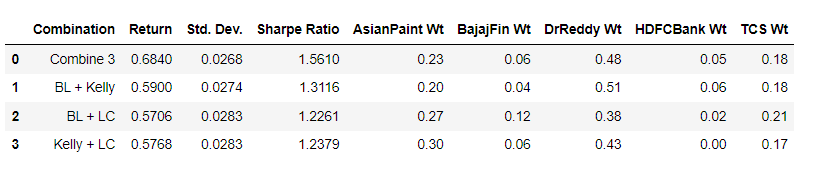

The combination (Combine 3) of the original "Optimal MV portfolio + Black Litterman (BL) + Kelly" was the best portfolio in terms of the Sharpe Ratio, Returns and Std. Dev. Hence we start with the portfolio weight for the 5 stocks in the ratio of 23%, 6%, 48%, 5% and 18%

#### B: Data Setup for the assignment

In [332]:
# Define the list of stock tickers
#tickers = ['ADANIENT.NS', 'TCS.NS', 'HDFCBANK.NS', 'DRREDDY.NS', 'ASIANPAINT.NS']
tickers = ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'DRREDDY.NS', 'HDFCBANK.NS', 'TCS.NS']

# Define the start and end dates. This will download 120 days of data for each stock
start_date = '2020-01-01'
end_date = '2023-06-30'

# Download historical price data
data = yf.download(tickers, start=start_date, end=end_date, period='1d', auto_adjust=True)['Close']

[*********************100%***********************]  5 of 5 completed


In [333]:
# Calculate the daily returns
act_returns = data.pct_change()
act_returns = act_returns.dropna()  # Drop the first row as it will have NaN due to no previous value

# Calculate the average daily return over the available data
avg_dly_return = act_returns.mean()
annualized_return = avg_dly_return * 252

# Assign the expected returns to the variable in the code
returns = np.array(annualized_return)
print(annualized_return)

ASIANPAINT.NS    0.227922
BAJAJFINSV.NS    0.223339
DRREDDY.NS       0.207744
HDFCBANK.NS      0.127856
TCS.NS           0.167451
dtype: float64


In [334]:
# Calculate the expected return for a 2-3 week period for each stock
short_period_in_years_2_weeks = 16 / 252
expected_returns_2_weeks = {}
expected_returns = []
# for stock, annualized_ret in annualized_return.items():
#     expected_returns_2_weeks[stock] = get_return_for_short_period(annualized_ret, short_period_in_years_2_weeks)

print("Expected Returns for 2 weeks:")
for stock, annualized_ret in annualized_return.items():
    expected_return_2_weeks = get_return_for_short_period(annualized_ret, short_period_in_years_2_weeks)
    expected_returns.append(expected_return_2_weeks)
    print(f"{stock}: {expected_return_2_weeks:.4f}")

print("")
print("Expected Returns:")
print(expected_returns)

Expected Returns for 2 weeks:
ASIANPAINT.NS: 0.0131
BAJAJFINSV.NS: 0.0129
DRREDDY.NS: 0.0121
HDFCBANK.NS: 0.0077
TCS.NS: 0.0099

Expected Returns:
[0.013121765943031383, 0.012881228023774893, 0.01205648420033456, 0.007668499774152737, 0.009878470900151592]


#### Step2 - Denoising (& Detoning) for the Portfolio

In [335]:
# Convert Close Prices to numpy array
S_value = data.values
S, _ = calculate_returns(S_value)
actual_corr = act_returns.corr()

# De-Noise
eVal0, eVec0, eVal1, eVec1, denoised_corr, var0 = denoise_OL(S, False)
# De-Tone
detoned_corr = eval_detoned_corr(denoised_corr, eVal1, eVec1)
denoised_corr_df = pd.DataFrame(denoised_corr, index=tickers, columns=tickers)

[]


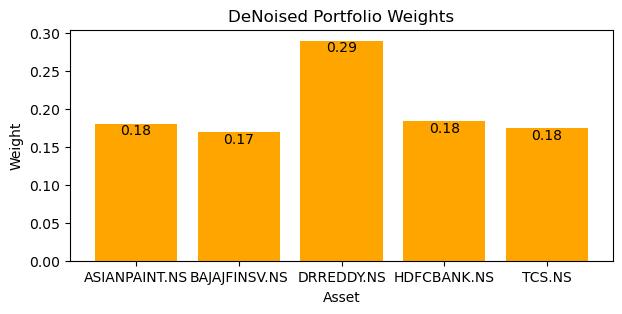

Denoised portfolio weights:
ASIANPAINT.NS: 0.1805
BAJAJFINSV.NS: 0.1699
DRREDDY.NS: 0.2902
HDFCBANK.NS: 0.1842
TCS.NS: 0.1752


In [336]:
# Example expected returns for the 5 stocks - replace with your actual data
# Populating with the annualized return for each stock
expected_returns = np.array([0.23, 0.22, 0.21, 0.13, 0.17])

# Perform mean-variance optimization
denoised_portfolio_weights = mean_variance_optimization(denoised_corr1, expected_returns)
plot_weights(denoised_portfolio_weights, 'DeNoised Portfolio Weights')
if denoised_portfolio_weights is not None:
    print("Denoised portfolio weights:")
    for i in range(len(denoised_portfolio_weights)):
        print(f"{tickers[i]}: {denoised_portfolio_weights[i]:.4f}")

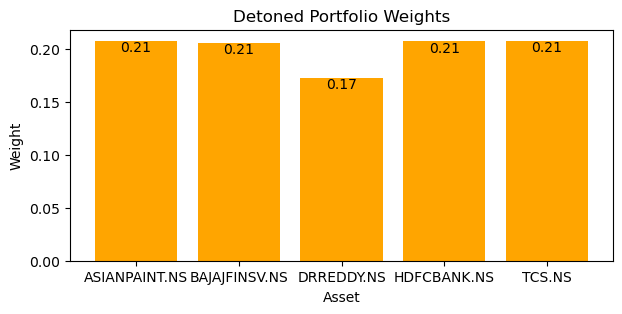

Detoned portfolio weights:
ASIANPAINT.NS: 0.2073
BAJAJFINSV.NS: 0.2057
DRREDDY.NS: 0.1727
HDFCBANK.NS: 0.2068
TCS.NS: 0.2075


In [337]:
# Perform mean-variance optimization
detoned_portfolio_weights = mean_variance_optimization(detoned_corr, expected_returns)
plot_weights(detoned_portfolio_weights, 'Detoned Portfolio Weights')
if detoned_portfolio_weights is not None:
    print("Detoned portfolio weights:")
    for i in range(len(detoned_portfolio_weights)):
        print(f"{tickers[i]}: {detoned_portfolio_weights[i]:.4f}")

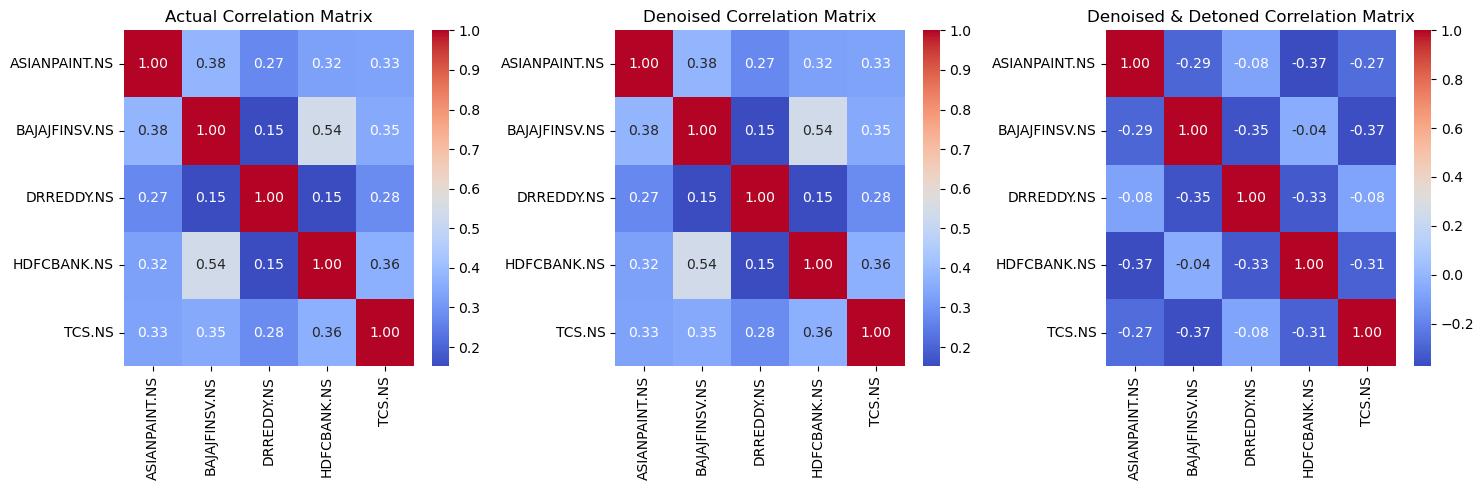

In [339]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first correlation matrix - actual_corr1
sns.heatmap(actual_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[0])
axs[0].set_title('Actual Correlation Matrix')

# Plot the second correlation matrix - denoised_corr1_df
denoised_corr_df = pd.DataFrame(denoised_corr, index=tickers, columns=tickers)
sns.heatmap(denoised_corr_df, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[1])
axs[1].set_title('Denoised Correlation Matrix')

# Plot the third correlation matrix - detoned_corr_df
detoned_corr_df = pd.DataFrame(detoned_corr, index=tickers, columns=tickers)
sns.heatmap(detoned_corr_df, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[2])
axs[2].set_title('Denoised & Detoned Correlation Matrix')

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Display the plots
plt.show()

#### Step 2 - Clustering of Portfolio:

In [340]:
q = 10.0
corr0 = act_returns.corr()
cov0 = act_returns.cov()
cols = cov0.columns
cov1 = deNoiseCov(cov0, q, bWidth=.01) #denoise cov
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)
corr1 = cov2corr(cov1)
clustered_corr, clstrs, silh = clusterKMeansBase(pd.DataFrame(corr0))

# code snippet 7.4 - intracluster optimal allocations
# step 2. compute intracluster allocations using the denoised cov matrix
wIntra = pd.DataFrame(0, index=cov0.index, columns=clstrs.keys())
for i in clstrs:
    wIntra.loc[clstrs[i], i] = minVarPort(cov1.loc[clstrs[i], clstrs[i]]).flatten()

cov2 = wIntra.T.dot(np.dot(cov1, wIntra)) #reduced covariance matrix

# code snippet 7.5 - intercluster optimal allocations
# step 3. compute optimal intercluster allocations, usint the reduced covariance matrix
# which is close to a diagonal matrix, so optimization problem is close to ideal case \ro =0
wInter = pd.Series(minVarPort(cov2).flatten(), index=cov2.index)
wAll0 = wIntra.mul(wInter, axis=1).sum(axis=1).sort_index()

# step 4. Final allocations - dot-product of the intra-cluster and inter-cluster allocations 
#w_nco = w_intra_clusters.mul(w_inter_clusters, axis=1).sum(axis=1).values.reshape(-1, 1)
nested_cluster_weights = wIntra.mul(wInter, axis=1).sum(axis=1).values.reshape(-1,1)

maxNumClusters2


In [341]:
print("Clusters Formed: ", clstrs)

Clusters Formed:  {0: ['DRREDDY.NS'], 1: ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS', 'TCS.NS']}


In [342]:
print("Silhouette:\n")
print(silh)

Silhouette:

ASIANPAINT.NS    0.056186
BAJAJFINSV.NS    0.186184
DRREDDY.NS       0.000000
HDFCBANK.NS      0.177169
TCS.NS           0.053897
dtype: float64


In [343]:
clstrs

{0: ['DRREDDY.NS'],
 1: ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'HDFCBANK.NS', 'TCS.NS']}

In [344]:
print("Inter Cluster Allocation: ")
print(wInter)

Inter Cluster Allocation: 
0    0.298356
1    0.701644
dtype: float64


**Two clusters are formed as a result of the clustering with inter cluster asllocation of 70% and 30%.
Given the silhouette numbers, we see that HDFCBANK and BAJAJFINSV (both financial sector) stocks are relatively better clustered  compared to ASIANPAINTS and TCS. DRREDDY is a separate cluster by itself.**

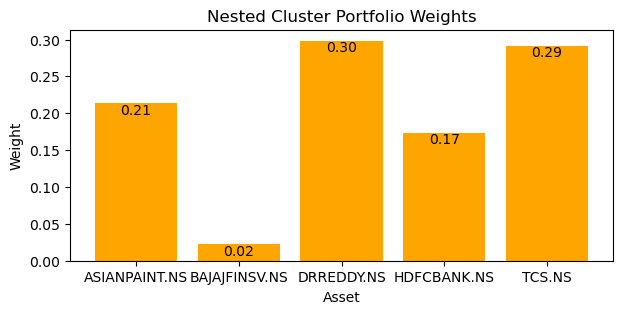

[0.21382444 0.02263147 0.29835589 0.1736967  0.2914915 ]


In [345]:
nested_cluster_wts = nested_cluster_weights.flatten()
plot_weights(nested_cluster_wts, 'Nested Cluster Portfolio Weights')
print(nested_cluster_wts)

#### Step 2 - Backtesting:

#### Benchmarked (NIFTY50) Sharpe Ratio:

In [346]:
nifty = yf.download('^NSEI', start=start_date, end=end_date, period='1d', auto_adjust=True)['Close']
nifty.index = pd.to_datetime(nifty.index)

# Calculate the daily returns of Nifty
daily_returns = nifty.pct_change()

# Calculate the average daily return and the standard deviation of daily returns
average_daily_return = daily_returns.mean()
daily_return_std = daily_returns.std()

# Assuming a risk-free rate (e.g., 0.03, which is 3% per annum)
risk_free_rate = 0.03 / 252  # Assuming daily compounding

# Calculate the risk premium as the difference between the average daily return and the risk-free rate
risk_premium = average_daily_return - risk_free_rate

# Calculate the Sharpe Ratio
benchmark_sharpe_ratio = (risk_premium / daily_return_std).round(4)

print("Nifty Sharpe Ratio:", sharpe_ratio)

[*********************100%***********************]  1 of 1 completed
Nifty Sharpe Ratio: 0.0361


In [347]:
from tqdm import tqdm
import scipy.stats as scipy_stats

M = 1000
df_pfs_returns = pd.DataFrame()

weights = []
l = [0.15, 0.22, 0.34, 0.18, 0.11]  # do not use 0, for avoiding zero division
for i in tqdm(range(M)):
    _weights = generate_random_weights(act_returns, l)
    _pf_returns = simulate(act_returns, _weights)
    df_pfs_returns[i] = _pf_returns
    weights.append(pd.Series(_weights.iloc[-1], name=i+1))
    
# Convert the list of Series to a DataFrame
weights_df = pd.DataFrame(weights)
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
psr = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=benchmark_sharpe_ratio).sort_values(ascending=False)

# Find the portfolio numbers with the best Sharpe Ratios
best_portfolio_numbers = psr.index[:5]  # Considering the top 5 best Sharpe Ratios

# Filter the weights DataFrame to include only the best portfolios
best_portfolio_weights_df = weights_df.loc[best_portfolio_numbers]

# Display the DataFrame with weights for the best portfolios
best_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0.0361).sort_values(ascending=False).index[0]
best_psr_pf_returns = df_pfs_returns[best_psr_pf_name]
best_portfolio_weights = weights_df.loc[best_psr_pf_name]
dsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=best_psr_pf_returns)
print("Deflated Sharpe Ratio: ", dsr)

100%|██████████| 1000/1000 [00:01<00:00, 765.40it/s]


Deflated Sharpe Ratio:  0.9647529787184895


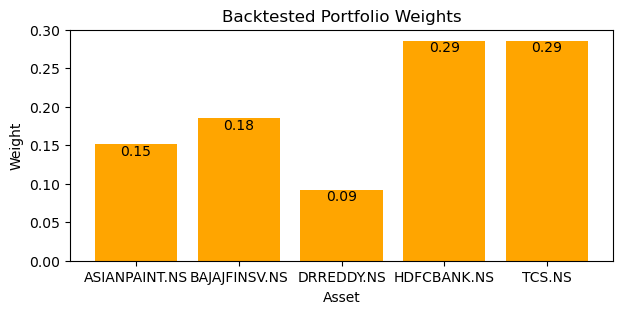

ASIANPAINT.NS    0.151261
BAJAJFINSV.NS    0.184874
DRREDDY.NS       0.092437
HDFCBANK.NS      0.285714
TCS.NS           0.285714
Name: 853, dtype: float64


In [348]:
plot_weights(best_portfolio_weights, 'Backtested Portfolio Weights')
print(best_portfolio_weights)

### Data for Testing Period - GWP2 to GWP3

In [349]:
# Define the list of stock tickers
#tickers = ['ADANIENT.NS', 'TCS.NS', 'HDFCBANK.NS', 'DRREDDY.NS', 'ASIANPAINT.NS']
tickers = ['ASIANPAINT.NS', 'BAJAJFINSV.NS', 'DRREDDY.NS', 'HDFCBANK.NS', 'TCS.NS']

# Define the start and end dates. This will download 120 days of data for each stock
gwp2_end_date = '2023-07-06'
gwp3_end_date = '2023-07-26'

# Download historical price data
test_data = yf.download(tickers, start=gwp2_end_date, end=gwp3_end_date, period='1d', auto_adjust=True)['Close']

[*********************100%***********************]  5 of 5 completed


In [378]:
test_data.head(3)

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Date,,,,,
2023-07-06,3399.399902,1619.900024,5191.203613,1675.000000,3314.281494
2023-07-07,3343.699951,1614.900024,5142.286133,1660.400024,3320.615234
2023-07-10,3343.149902,1597.800049,5114.950195,1656.449951,3263.463623


In [379]:
test_data.tail(3)

,ASIANPAINT.NS,BAJAJFINSV.NS,DRREDDY.NS,HDFCBANK.NS,TCS.NS
Date,,,,,
2023-07-21,3517.699951,1632.849976,5288.200195,1675.750000,3368.300049
2023-07-24,3543.699951,1657.500000,5391.700195,1678.400024,3394.750000
2023-07-25,3400.399902,1648.849976,5425.399902,1696.599976,3399.149902


In [350]:
# Calculate daily returns for each stock
returns = test_data.pct_change().dropna()

In [351]:
# Create an empty DataFrame with specified columns
model_test_df = pd.DataFrame(columns=['Model', 'AsianPaint Wt.', 'BajajFinSv Wt.', 'DrReddy Wt.', 'HDFCBank Wt.', 'TCS Wt.',
                                      'Port. Returns%', 'Sharpe Ratio', 'Std Dev', 'Max Drawdown', 'Sortino Ratio'])

In [352]:
def calc_model_returns(returns, weights):
    # Calculate the portfolio return for each day
    portfolio_returns = returns.dot(weights)

    # Calculate the overall portfolio return
    overall_portfolio_return = (1 + portfolio_returns).cumprod()[-1] - 1

    # Convert portfolio_return to percentage
    overall_portfolio_return_pct = overall_portfolio_return * 100

    # Calculate the portfolio standard deviation (volatility)
    portfolio_std_dev = np.std(portfolio_returns)

    # Calculate the Sharpe Ratio
    risk_free_rate = 0.0  # Replace with the appropriate risk-free rate if available
    excess_returns = portfolio_returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / portfolio_std_dev

    # Calculate the maximum drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    max_drawdown = cumulative_returns.div(cumulative_returns.cummax()).sub(1).min()

    # Calculate the Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    sortino_ratio = np.mean(excess_returns) / np.std(downside_returns)

    return overall_portfolio_return_pct, portfolio_std_dev, sharpe_ratio, max_drawdown, sortino_ratio


In [353]:
def store_results(model_name, weights, results):
    global model_test_df

    # Create a dictionary to store all the data
    data = {}

    # Store the model name
    data['Model'] = model_name

    # Store the weights
    data['AsianPaint Wt.'] = round(weights[0], 4)
    data['BajajFinSv Wt.'] = round(weights[1], 4)
    data['DrReddy Wt.'] = round(weights[2], 4)
    data['HDFCBank Wt.'] = round(weights[3], 4)
    data['TCS Wt.'] = round(weights[4], 4)

    # Store the model results
    data['Port. Returns%'] = round(results[0], 4)
    data['Sharpe Ratio'] = round(results[1], 4)
    data['Std Dev'] = round(results[2], 4)
    data['Max Drawdown'] = round(results[3], 4)
    data['Sortino Ratio'] = round(results[4], 4)

    # Append data to the DataFrame
    model_test_df = model_test_df.append(data, ignore_index=True)

In [354]:
# GWP2 Best Portfolio
gwp2_best_portfolio_weights = [0.23, 0.06, 0.48, 0.05, 0.18]
results = calc_model_returns(returns, gwp2_best_portfolio_weights)
# Store the results in the DataFrame
store_results('GWP2[Optimal+BL+Kelly]', gwp2_best_portfolio_weights, results)

In [355]:
# Denoised Portfolio
results = calc_model_returns(returns, denoised_portfolio_weights)
# Store the results in the DataFrame
store_results('Denoised', denoised_portfolio_weights, results)

In [356]:
# Detoned Portfolio
results = calc_model_returns(returns, detoned_portfolio_weights)
# Store the results in the DataFrame
store_results('Detoned', detoned_portfolio_weights, results)

In [357]:
# Clustered Portfolio
results = calc_model_returns(returns, nested_cluster_wts)
# Store the results in the DataFrame
store_results('Clustered', nested_cluster_wts, results)

In [358]:
# Backtested Portfolio
results = calc_model_returns(returns, best_portfolio_weights)
# Store the results in the DataFrame
store_results('Backtested', best_portfolio_weights, results)

### Multiple Improvements:

#### 1. Denoised & Clustered:

In [359]:
q = 10.0

# Input the denoised corr
corr0 = denoised_corr_df
#=========================
#cov0 = act_returns.cov()
cov0 = corr2cov(denoised_corr_df, act_returns.std())

cols = cov0.columns
cov1 = deNoiseCov(cov0, q, bWidth=.01) #denoise cov
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)
corr1 = cov2corr(cov1)
denoised_clustered_corr, denoised_clstrs, denoised_silh = clusterKMeansBase(pd.DataFrame(corr0))

# code snippet 7.4 - intracluster optimal allocations
# step 2. compute intracluster allocations using the denoised cov matrix
wIntra = pd.DataFrame(0, index=cov0.index, columns=denoised_clstrs.keys())
for i in denoised_clstrs:
    wIntra.loc[denoised_clstrs[i], i] = minVarPort(cov1.loc[denoised_clstrs[i], denoised_clstrs[i]]).flatten()

cov2 = wIntra.T.dot(np.dot(cov1, wIntra)) #reduced covariance matrix

# code snippet 7.5 - intercluster optimal allocations
# step 3. compute optimal intercluster allocations, usint the reduced covariance matrix
# which is close to a diagonal matrix, so optimization problem is close to ideal case \ro =0
denoised_wInter = pd.Series(minVarPort(cov2).flatten(), index=cov2.index)
wAll0 = wIntra.mul(denoised_wInter, axis=1).sum(axis=1).sort_index()

# step 4. Final allocations - dot-product of the intra-cluster and inter-cluster allocations 
#w_nco = w_intra_clusters.mul(w_inter_clusters, axis=1).sum(axis=1).values.reshape(-1, 1)
denoised_cluster_weights = wIntra.mul(denoised_wInter, axis=1).sum(axis=1).values.reshape(-1,1)

maxNumClusters2


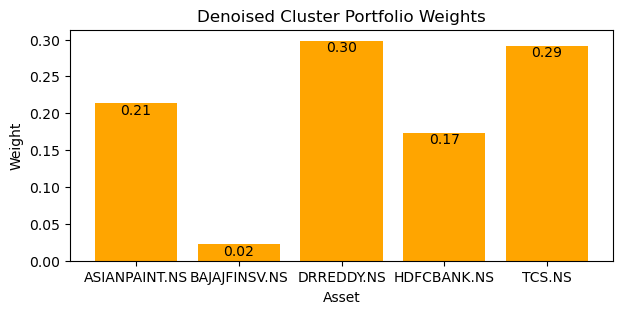

[0.21382444 0.02263147 0.29835589 0.1736967  0.2914915 ]


In [360]:
denoised_cluster_wts = denoised_cluster_weights.flatten()
plot_weights(denoised_cluster_wts, 'Denoised Cluster Portfolio Weights')
print(denoised_cluster_wts)

In [361]:
# Denoised & Clustered
results = calc_model_returns(returns, denoised_cluster_wts )
# Store the results in the DataFrame
store_results('Denoised & Clustered', denoised_cluster_wts , results)

#### 2. Denoised & Backtested:

In [363]:
from tqdm import tqdm
import scipy.stats as scipy_stats

M = 1000
df_pfs_returns = pd.DataFrame()

denoised_backtest_weights = []
for i in tqdm(range(M)):
    _weights = generate_random_weights(act_returns, denoised_portfolio_weights)
    _pf_returns = simulate(act_returns, _weights)
    df_pfs_returns[i] = _pf_returns
    denoised_backtest_weights.append(pd.Series(_weights.iloc[-1], name=i+1))

# Convert the list of Series to a DataFrame
denoised_backtest_weights_df = pd.DataFrame(denoised_backtest_weights)
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
psr = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=benchmark_sharpe_ratio).sort_values(ascending=False)

# Find the portfolio numbers with the best Sharpe Ratios
denoised_backtest_portfolio_numbers = psr.index[:5]  # Considering the top 5 best Sharpe Ratios

# Filter the weights DataFrame to include only the best portfolios
denoised_backtest_portfolio_weights_df = denoised_backtest_weights_df.loc[denoised_backtest_portfolio_numbers]

# Display the DataFrame with weights for the best portfolios
denoised_backtest_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0.0361).sort_values(ascending=False).index[0]
denoised_backtest_psr_pf_returns = df_pfs_returns[denoised_backtest_psr_pf_name]
denoised_backtest_portfolio_weights = denoised_backtest_weights_df.loc[denoised_backtest_psr_pf_name]
denoised_backtestdsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=denoised_backtest_psr_pf_returns)
print("Deflated Sharpe Ratio: ", denoised_backtestdsr)

100%|██████████| 1000/1000 [00:01<00:00, 742.68it/s]


Deflated Sharpe Ratio:  0.9656442175224179


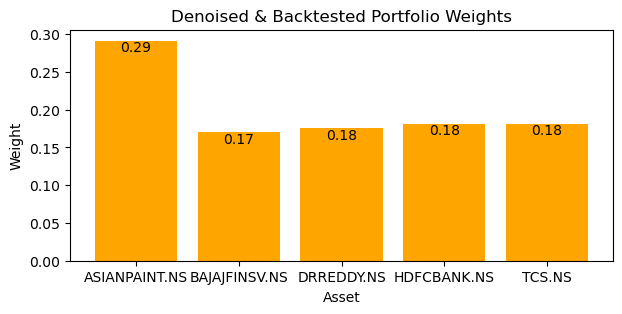

ASIANPAINT.NS    0.291292
BAJAJFINSV.NS    0.170500
DRREDDY.NS       0.175853
HDFCBANK.NS      0.181177
TCS.NS           0.181177
Name: 651, dtype: float64


In [364]:
plot_weights(denoised_backtest_portfolio_weights, 'Denoised & Backtested Portfolio Weights')
print(denoised_backtest_portfolio_weights)

In [365]:
# Denoised & Backtested Portfolio Weights
results = calc_model_returns(returns, denoised_backtest_portfolio_weights)
# Store the results in the DataFrame
store_results('Denoised & Backtested', denoised_backtest_portfolio_weights, results)

#### 3. Clustered & Backtested:

In [366]:
from tqdm import tqdm
import scipy.stats as scipy_stats

M = 1000
df_pfs_returns = pd.DataFrame()

clustered_backtest_weights = []
nested_cluster_wts = nested_cluster_weights.flatten()

for i in tqdm(range(M)):
    _weights = generate_random_weights(act_returns, nested_cluster_wts)
    _pf_returns = simulate(act_returns, _weights)
    df_pfs_returns[i] = _pf_returns
    clustered_backtest_weights.append(pd.Series(_weights.iloc[-1], name=i+1))
    
# Convert the list of Series to a DataFrame
clustered_backtest_weights_df = pd.DataFrame(clustered_backtest_weights)
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
psr = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=benchmark_sharpe_ratio).sort_values(ascending=False)

# Find the portfolio numbers with the best Sharpe Ratios
clustered_backtest_portfolio_numbers = psr.index[:5]  # Considering the top 5 best Sharpe Ratios

# Filter the weights DataFrame to include only the best portfolios
clustered_backtest_portfolio_weights_df = clustered_backtest_weights_df.loc[clustered_backtest_portfolio_numbers]

# Display the DataFrame with weights for the best portfolios
clustered_backtest_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0.0361).sort_values(ascending=False).index[0]
clustered_backtest_psr_pf_returns = df_pfs_returns[clustered_backtest_psr_pf_name]
clustered_backtest_portfolio_weights = clustered_backtest_weights_df.loc[clustered_backtest_psr_pf_name]
clustered_backtestdsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=clustered_backtest_psr_pf_returns)
print("Deflated Sharpe Ratio: ", clustered_backtestdsr)

100%|██████████| 1000/1000 [00:01<00:00, 768.64it/s]


Deflated Sharpe Ratio:  0.9645020380540943


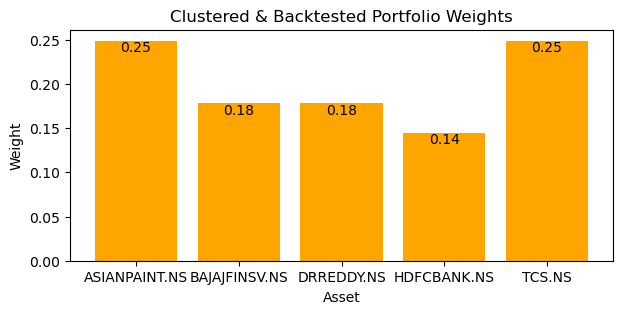

ASIANPAINT.NS    0.249033
BAJAJFINSV.NS    0.178476
DRREDDY.NS       0.178476
HDFCBANK.NS      0.144982
TCS.NS           0.249033
Name: 336, dtype: float64


In [367]:
plot_weights(clustered_backtest_portfolio_weights, 'Clustered & Backtested Portfolio Weights')
print(clustered_backtest_portfolio_weights)

In [368]:
# Clustered & Backtested
results = calc_model_returns(returns, clustered_backtest_portfolio_weights)
# Store the results in the DataFrame
store_results('Clustered & Backtested', clustered_backtest_portfolio_weights, results)

#### 4. Denoised, Clustered & Backtested:

In [369]:
from tqdm import tqdm
import scipy.stats as scipy_stats

M = 1000
df_pfs_returns = pd.DataFrame()

denoised_clustered_backtest_weights = []
denoised_cluster_wts = denoised_cluster_weights.flatten()

for i in tqdm(range(M)):
    _weights = generate_random_weights(act_returns, denoised_cluster_wts)
    _pf_returns = simulate(act_returns, _weights)
    df_pfs_returns[i] = _pf_returns
    denoised_clustered_backtest_weights.append(pd.Series(_weights.iloc[-1], name=i+1))
    
# Convert the list of Series to a DataFrame
denoised_clustered_backtest_weights_df = pd.DataFrame(denoised_clustered_backtest_weights)
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
psr = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=benchmark_sharpe_ratio).sort_values(ascending=False)

# Find the portfolio numbers with the best Sharpe Ratios
denoised_clustered_backtest_portfolio_numbers = psr.index[:5]  # Considering the top 5 best Sharpe Ratios

# Filter the weights DataFrame to include only the best portfolios
denoised_clustered_backtest_portfolio_weights_df = denoised_clustered_backtest_weights_df.loc[denoised_clustered_backtest_portfolio_numbers]

# Display the DataFrame with weights for the best portfolios
denoised_clustered_backtest_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0.0361).sort_values(ascending=False).index[0]
denoised_clustered_backtest_psr_pf_returns = df_pfs_returns[denoised_clustered_backtest_psr_pf_name]
denoised_clustered_backtest_portfolio_weights = denoised_clustered_backtest_weights_df.loc[denoised_clustered_backtest_psr_pf_name]
denoised_clustered_backtestdsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=denoised_clustered_backtest_psr_pf_returns)
print("Deflated Sharpe Ratio: ", denoised_clustered_backtestdsr)

100%|██████████| 1000/1000 [00:01<00:00, 667.36it/s]


Deflated Sharpe Ratio:  0.9730905533040477


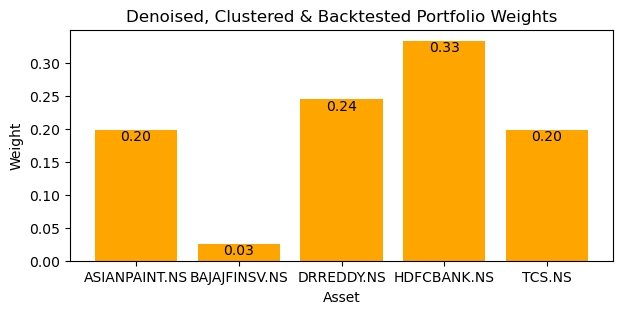

ASIANPAINT.NS    0.198433
BAJAJFINSV.NS    0.025854
DRREDDY.NS       0.244276
HDFCBANK.NS      0.333003
TCS.NS           0.198433
Name: 421, dtype: float64


In [370]:
plot_weights(denoised_clustered_backtest_portfolio_weights, 'Denoised, Clustered & Backtested Portfolio Weights')
print(denoised_clustered_backtest_portfolio_weights)

In [371]:
# Denoised Clustered & Backtested
results = calc_model_returns(returns, denoised_clustered_backtest_portfolio_weights)
# Store the results in the DataFrame
store_results('Denoised Clustered & Backtested', denoised_clustered_backtest_portfolio_weights, results)

In [372]:
model_test_df

,Model,AsianPaint Wt.,BajajFinSv Wt.,DrReddy Wt.,HDFCBank Wt.,TCS Wt.,Port. Returns%,Sharpe Ratio,Std Dev,Max Drawdown,Sortino Ratio
0,GWP2[Optimal+BL+Kelly],0.2300,0.0600,0.4800,0.0500,0.1800,2.8747,0.0081,0.2742,-0.0106,1.1873
1,Denoised,0.1805,0.1699,0.2902,0.1842,0.1752,2.3723,0.0068,0.2679,-0.0097,0.5627
2,Detoned,0.2073,0.2057,0.1727,0.2068,0.2075,2.0217,0.0068,0.2287,-0.0098,0.5400
3,Clustered,0.2138,0.0226,0.2984,0.1737,0.2915,2.4442,0.0079,0.2382,-0.0127,0.4737
4,Backtested,0.1513,0.1849,0.0924,0.2857,0.2857,1.9242,0.0074,0.2010,-0.0116,0.4481
5,Denoised & Clustered,0.2138,0.0226,0.2984,0.1737,0.2915,2.4442,0.0079,0.2382,-0.0127,0.4737
6,Denoised & Backtested,0.2913,0.1705,0.1759,0.1812,0.1812,1.8745,0.0071,0.2054,-0.0094,0.4349
7,Clustered & Backtested,0.2490,0.1785,0.1785,0.1450,0.2490,2.0325,0.0074,0.2125,-0.0106,0.4654
8,Denoised Clustered & Backtested,0.1984,0.0259,0.2443,0.3330,0.1984,2.1598,0.0071,0.2347,-0.0109,0.5028


When compared to the ‘best’ portfolio in terms of superior risk-reward ratio, the GWP2 combined model of MVO+BL+Kelly still stands out compared to any of the models developed by denoising, clustering or backtesting.</br>
Models based on clustering is next based, followed by denoising and then backtesting.</br></br>
Constraining the exercise to 5 stocks and testing the models over a small period of 14 days may not have been sufficient to train and then test the model. Yet clustering and denoising is pretty close to the best portfolio. Backtesting in its nature is conservative in approach to remove effects of “sins”. Backtesting models are less volatile and that is the only metric in its favour.</br></br>
This exercise does not provide evidence that the complexity of building the models justify the effort for a risk-taking investor. However, this exercise is worthy to be carried out for risk-averse investor.

#### Conclusion:

The exercise was conducted using only one type of asset which were stocks. Other constraints like the number of assets and the testing time period also may have affected the observed outcomes.</br>
The models are complex and application of those tend to make the portfolio constructed more balanced for risk-nuetral and risk-averse institutions and investors.</br></br>
Using correlation and covariance matrix to develop the model is a good approach for quants and financial engineers. In terms of interpretability the change in allocation is a good way to show the outcome. However, explaining the why is tad bit difficult and will require more visualization that we could use in this assignment.</br></br>
There is a appreciable observable difference in results using these models, although in terms of performance it did not improve to the model explored earlier in GWP2. Notwithstanding the constraints, these models do have merit and it is worth the effort for financial engineers and serious investors.

### Reference & Code credit:

Denoising & Clustering Code:</br>
https://github.com/emoen/Machine-Learning-for-Asset-Managers</br>
Implementation of code snippets and exercises from Machine Learning for Asset Managers (Elements in Quantitative Finance) written by Prof. Marcos López de Prado.

Backtesting Code:</br>
https://github.com/rubenbriones/Probabilistic-Sharpe-Ratio/tree/master</br>
Probabilistic Sharpe Ratio example in Python (by Marcos López de Prado)